載入所需函式庫

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from google.colab import drive
drive.mount("/content/drive")
%matplotlib inline

載入相關資料

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/data2/train.csv")
test = pd.read_csv("/content/drive/MyDrive/data2/test_3000.csv")

In [ ]:
train

,song_id,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,Feature 11,Feature 12,Feature 13
0,0,0.14700,0.798,0.745,46,111.016,0.1970,0.388,240000,-5.436,0.0384,1,0.651000,F
1,1,0.06580,0.804,0.521,66,143.952,0.0521,0.553,224700,-4.395,0.0569,0,0.000000,C
2,2,0.03950,0.960,0.755,67,99.023,0.3320,0.661,170440,-3.189,0.1230,1,0.000024,E
3,3,0.35900,0.769,0.592,40,171.940,0.1220,0.223,226520,-7.127,0.1900,1,0.014300,D
4,4,0.16000,0.838,0.769,83,93.996,0.0935,0.602,249609,-5.238,0.0633,0,0.000000,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40109,40109,0.00923,0.760,0.761,48,144.977,0.4690,0.492,249667,-6.275,0.3780,0,0.000000,D
40110,40110,0.43000,0.533,0.495,50,79.710,0.1060,0.424,247055,-5.802,0.0295,1,0.000672,C
40111,40111,0.03280,0.823,0.562,43,126.023,0.2120,0.376,194293,-4.732,0.0405,0,0.000002,B
40112,40112,0.82500,0.281,0.420,46,89.423,0.1990,0.792,391613,-15.291,0.0445,0,0.000135,C#


刪除song_id，因為跟資料預測沒有關係

In [ ]:
train = train.drop(['song_id'], axis = 1)

觀察類別型特徵有那一些

In [ ]:
categorical = train.select_dtypes(include=['object'])
categorical

,Feature 13
0,F
1,C
2,E
3,D
4,D
...,...
40109,D
40110,C
40111,B
40112,C#


觀察類別型特徵中的標籤數量

In [ ]:
train['Feature 13'].unique()

array(['F', 'C', 'E', 'D', 'A', 'A#', 'C#', 'B', 'G', 'D#', 'G#', 'F#'],
      dtype=object)

In [ ]:
for i in categorical:
    print(i, ' contains ', train[i].nunique(), ' labels')

Feature 13  contains  12  labels


將類別資料按照Pitch class轉換成數值資料

In [ ]:
mapping = {'F': 5, 'C': 0, 'E': 4, 'D': 2, 'A': 9, 'A#': 10, 'C#': 1, 'B': 11, 
        'G': 7, 'D#': 3, 'G#': 8, 'F#': 6}
train['Feature 13'] = train['Feature 13'].map(mapping)
train

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,Feature 11,Feature 12,Feature 13
0,0.14700,0.798,0.745,46,111.016,0.1970,0.388,240000,-5.436,0.0384,1,0.651000,5
1,0.06580,0.804,0.521,66,143.952,0.0521,0.553,224700,-4.395,0.0569,0,0.000000,0
2,0.03950,0.960,0.755,67,99.023,0.3320,0.661,170440,-3.189,0.1230,1,0.000024,4
3,0.35900,0.769,0.592,40,171.940,0.1220,0.223,226520,-7.127,0.1900,1,0.014300,2
4,0.16000,0.838,0.769,83,93.996,0.0935,0.602,249609,-5.238,0.0633,0,0.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40109,0.00923,0.760,0.761,48,144.977,0.4690,0.492,249667,-6.275,0.3780,0,0.000000,2
40110,0.43000,0.533,0.495,50,79.710,0.1060,0.424,247055,-5.802,0.0295,1,0.000672,0
40111,0.03280,0.823,0.562,43,126.023,0.2120,0.376,194293,-4.732,0.0405,0,0.000002,11
40112,0.82500,0.281,0.420,46,89.423,0.1990,0.792,391613,-15.291,0.0445,0,0.000135,1


特徵標準化

In [ ]:
scaler = StandardScaler().fit(train)
train_scaled = scaler.transform(train)
train_scaled = pd.DataFrame(train_scaled, columns=train.columns)
train_scaled

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,Feature 11,Feature 12,Feature 13
0,-0.467061,0.750530,1.039161,0.099224,-0.287206,0.019140,-0.278654,-0.050946,0.601983,-0.546951,1.332904,1.445996,-0.064287
1,-0.705215,0.773241,-0.213183,1.391453,0.788367,-0.876465,0.389370,-0.189563,0.771083,-0.365293,-0.750242,-0.556674,-1.468112
2,-0.782352,1.363715,1.095069,1.456065,-0.678855,0.853555,0.826622,-0.681155,0.966985,0.283766,1.332904,-0.556599,-0.345052
3,0.154723,0.640763,0.183765,-0.288445,1.702355,-0.444424,-0.946678,-0.173074,0.327298,0.941662,1.332904,-0.512683,-0.906582
4,-0.428932,0.901934,1.173341,2.489849,-0.843019,-0.620578,0.587753,0.036111,0.634146,-0.302449,-0.750242,-0.556674,-0.906582
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40109,-0.871132,0.606697,1.128614,0.228447,0.821839,1.700331,0.142404,0.036637,0.465696,2.787700,-0.750242,-0.556674,-0.906582
40110,0.362962,-0.252519,-0.358545,0.357670,-1.309549,-0.543317,-0.132903,0.012972,0.542530,-0.634343,1.332904,-0.554607,-1.468112
40111,-0.802002,0.845158,0.016040,-0.094611,0.202869,0.111853,-0.327237,-0.465048,0.716340,-0.526331,-0.750242,-0.556669,1.620302
40112,1.521473,-1.206362,-0.777857,0.099224,-0.992357,0.031502,1.356993,1.322658,-0.998858,-0.487053,-0.750242,-0.556259,-1.187347


使用熱力圖觀察特徵間的關聯程度

[Text(0, 0.5, 'Feature 1'),
 Text(0, 1.5, 'Feature 2'),
 Text(0, 2.5, 'Feature 3'),
 Text(0, 3.5, 'Feature 4'),
 Text(0, 4.5, 'Feature 5'),
 Text(0, 5.5, 'Feature 6'),
 Text(0, 6.5, 'Feature 7'),
 Text(0, 7.5, 'Feature 8'),
 Text(0, 8.5, 'Feature 9'),
 Text(0, 9.5, 'Feature 10'),
 Text(0, 10.5, 'Feature 11'),
 Text(0, 11.5, 'Feature 12'),
 Text(0, 12.5, 'Feature 13')]

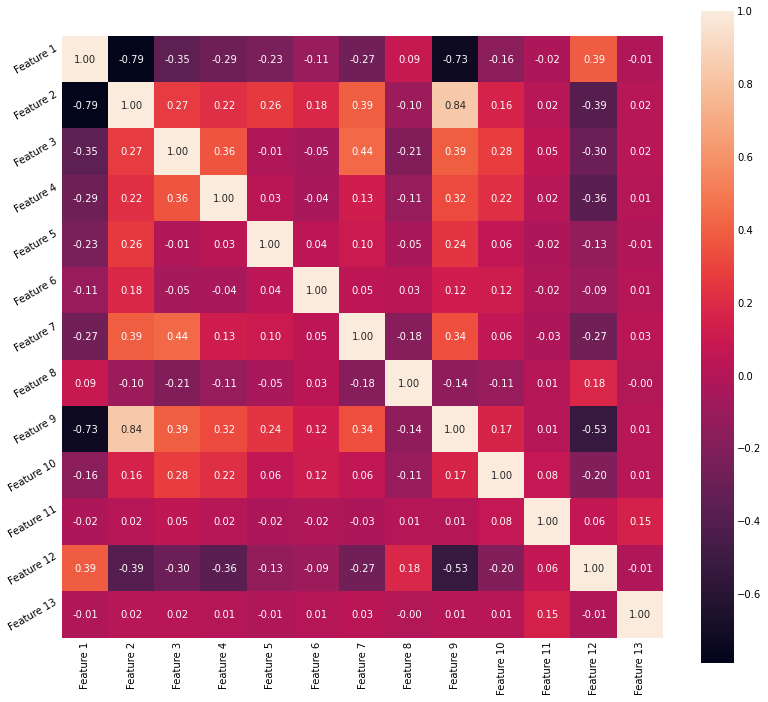

In [ ]:
# 計算特徵之間的相關係數
corr = train.corr()
plt.figure(figsize=(12,12))
ax = sns.heatmap(corr, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)   

刪除特徵6、8，及刪除相關度高的2與9其中一個

In [ ]:
train_scaled = train_scaled.drop(['Feature 2'], axis = 1)
train_scaled = train_scaled.drop(['Feature 6'], axis = 1)
train_scaled = train_scaled.drop(['Feature 8'], axis = 1)

,Feature 1,Feature 3,Feature 4,Feature 5,Feature 7,Feature 9,Feature 10,Feature 11,Feature 12,Feature 13
0,-0.467061,1.039161,0.099224,-0.287206,-0.278654,0.601983,-0.546951,1.332904,1.445996,-0.064287
1,-0.705215,-0.213183,1.391453,0.788367,0.389370,0.771083,-0.365293,-0.750242,-0.556674,-1.468112
2,-0.782352,1.095069,1.456065,-0.678855,0.826622,0.966985,0.283766,1.332904,-0.556599,-0.345052
3,0.154723,0.183765,-0.288445,1.702355,-0.946678,0.327298,0.941662,1.332904,-0.512683,-0.906582
4,-0.428932,1.173341,2.489849,-0.843019,0.587753,0.634146,-0.302449,-0.750242,-0.556674,-0.906582
...,...,...,...,...,...,...,...,...,...,...
40109,-0.871132,1.128614,0.228447,0.821839,0.142404,0.465696,2.787700,-0.750242,-0.556674,-0.906582
40110,0.362962,-0.358545,0.357670,-1.309549,-0.132903,0.542530,-0.634343,1.332904,-0.554607,-1.468112
40111,-0.802002,0.016040,-0.094611,0.202869,-0.327237,0.716340,-0.526331,-0.750242,-0.556669,1.620302
40112,1.521473,-0.777857,0.099224,-0.992357,1.356993,-0.998858,-0.487053,-0.750242,-0.556259,-1.187347


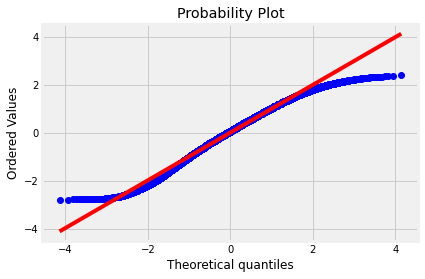

In [ ]:
res = stats.probplot(train_scaled['Feature 3'], plot=plt)

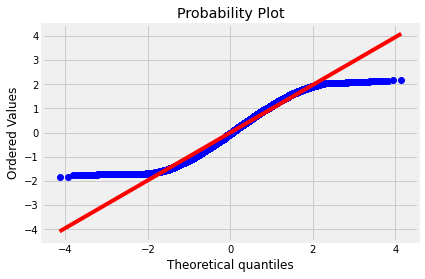

In [ ]:
res = stats.probplot(train_scaled['Feature 7'], plot=plt)

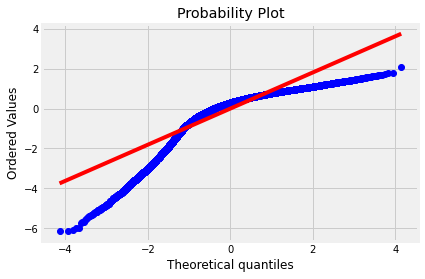

In [ ]:
res = stats.probplot(train_scaled['Feature 9'], plot=plt)

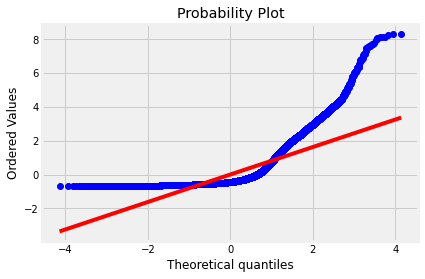

In [ ]:
res = stats.probplot(train_scaled['Feature 10'], plot=plt)

觀察峰度

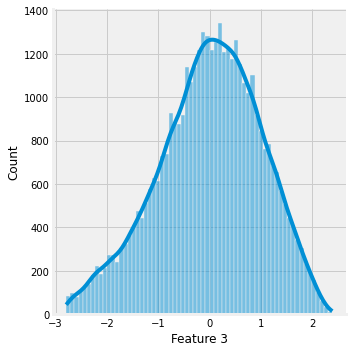

In [ ]:
sns.displot(train_scaled['Feature 3'], kde=True)

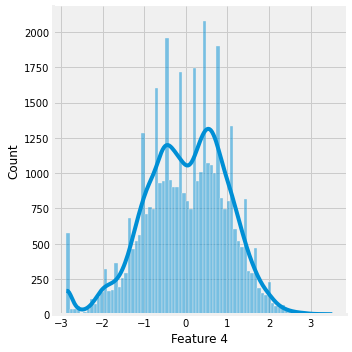

In [ ]:
sns.displot(train_scaled['Feature 4'], kde=True)

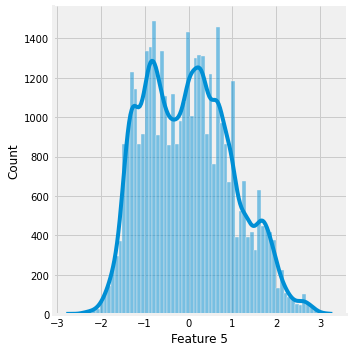

In [ ]:
sns.displot(train_scaled['Feature 5'], kde=True)

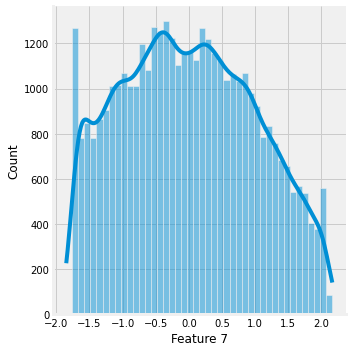

In [ ]:
sns.displot(train_scaled['Feature 7'], kde=True)

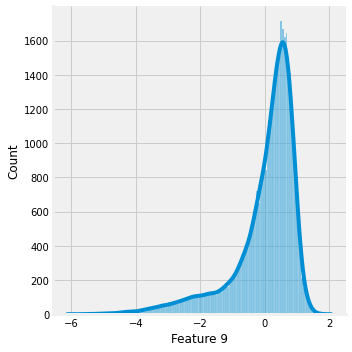

In [ ]:
sns.displot(train_scaled['Feature 9'], kde=True)

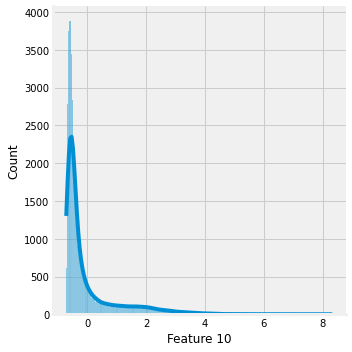

In [ ]:
sns.displot(train_scaled['Feature 10'], kde=True)

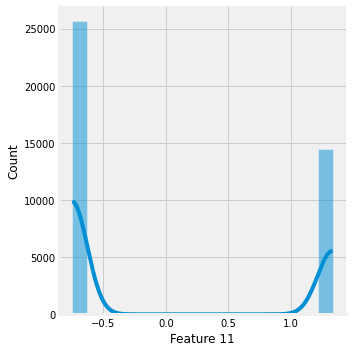

In [ ]:
sns.displot(train_scaled['Feature 11'], kde=True)

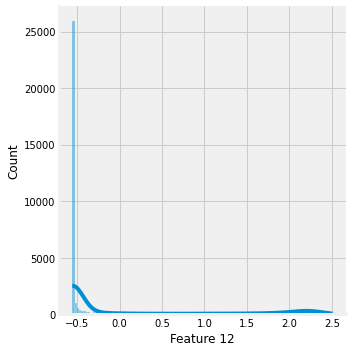

In [ ]:
sns.displot(train_scaled['Feature 12'], kde=True)

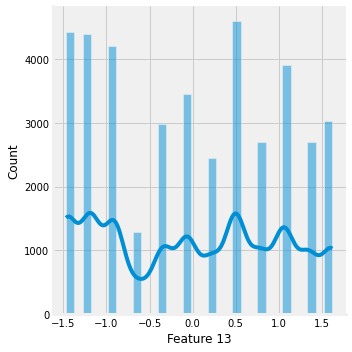

In [ ]:
sns.displot(train_scaled['Feature 13'], kde=True)

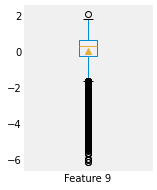

In [ ]:
def Detect_outliers(df, feature_name):
  plt.figure(figsize=(2,3))
  df.boxplot(column = feature_name, grid = False, showmeans = True)
Detect_outliers(train_scaled, "Feature 9")

訓練並預測

In [ ]:
# 宣告 KMean 分群器, 對 X 訓練並預測
clusterer = KMeans(n_clusters = 2)
cluster_labels = clusterer.fit_predict(train_scaled)

答案輸出成CSV

In [ ]:
kmeans_label = clusterer.labels_
ans = np.empty(test.shape[0], dtype=int)

for i in range(test.shape[0]):
  if kmeans_label[test.at[i, 'col_1']] == kmeans_label[test.at[i, 'col_2']] and DBSCAN_label[test.at[i, 'col_1']] == DBSCAN_label[test.at[i, 'col_2']]:
    ans[i] = 1
  else:
    ans[i] = 0

output = pd.DataFrame(ans)
output.to_csv("submission.csv",header=['ans'],index_label='id')

